In [1]:
#from docopt import docopt
import numpy as np
import matplotlib.pyplot as plt
# Extract Features from a trained net via forward pass
import os
import sys
import tables as tb
import h5py as h5
from scipy import stats
import subprocess as sub
from sklearn.metrics import mean_squared_error as mse
import collections
import pickle

# dictionaries for summarized results
boxplot_config_r = collections.defaultdict(list)
boxplot_config_MSE = collections.defaultdict(list)

In [9]:
def plot_from_logs(train_file, valid_file, log_title):
    '''
    Training Log Header:
    #Iters Seconds TrainingLoss LearningRate

    Valid Log Header:
    #Iters Seconds TestAccuracy TestLoss

    :param train_file:
    :param valid_file:
    :return:
    '''
    #tX = np.loadtxt(train_file, skiprows=1)    
    #vX = np.loadtxt(valid_file, skiprows=1)
    tX = np.genfromtxt(train_file, dtype=float, delimiter=',',skip_header=1)     
    vX = np.genfromtxt(valid_file, dtype=float, delimiter=',',skip_header=1) 
    
    t_iters = tX[:, 0]
    v_iters = vX[:, 0]
    seconds = tX[:, 1]

    # Training loss and validation accuracy:    
    #plt.subplot(211)    
    p1, = plt.plot(t_iters, tX[:, 3],  label="Training Loss")
    p2, = plt.plot(v_iters, vX[:, 3],  linewidth=2, label="Validation Accuracy")
    plt.xlabel('Iterations')
    plt.ylabel('Loss/Accuracy')
    plt.title(log_title)
    plt.legend()
    #plt.xlim([1000,15000])
    #plt.legend(bbox_to_anchor=(0.,1.02, 1., 0.102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    
    # Learning rate:
    #plt.subplot(212)
    #p3, = plt.plot(t_iters, tX[:, 2], label="Learning Rate: " + log_title)
    #plt.xlabel('Iterations')
    #plt.ylabel('Learning Rate')
    #plt.legend(loc=1)
    #plt.ylim([0,0.01])
    #plt.grid()

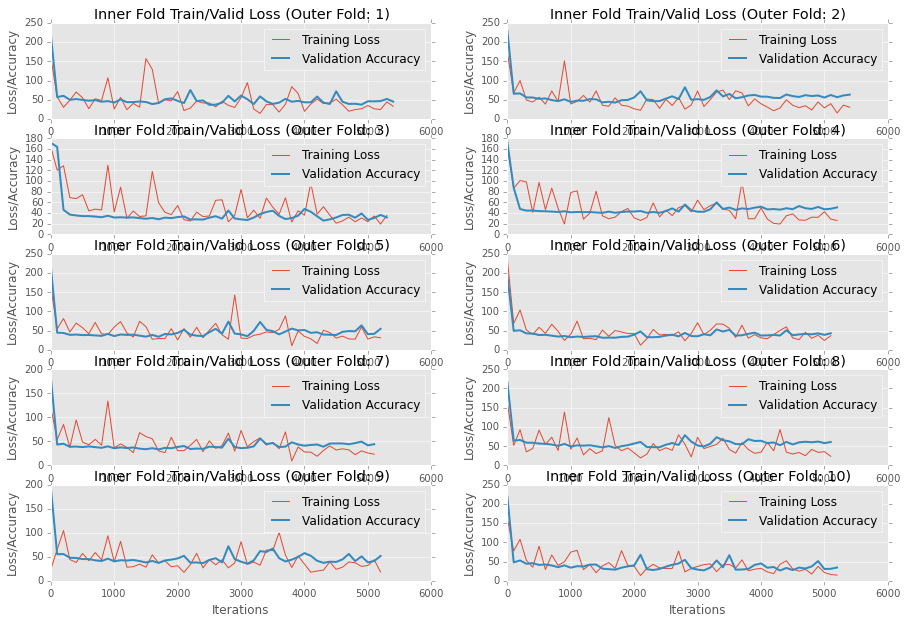

In [24]:
#plt.figure()
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('ggplot')

baseline_dir= '/projects/nikhil/ADNI_prediction/caffe_output/'
n_folds = 10
n_cols = 2
n_rows = (n_folds+1)/n_cols
tid = 21
modality = 'HC_CT'

for lid in np.arange(1,n_folds+1,1):    
    plt.subplot(n_rows,n_cols,lid)
    train_file = '{}OuterFold{}/caffe.INFO.{}_ff_OF{}_{}_T{}'.format(baseline_dir,lid,'train',lid,modality,tid)
    valid_file = '{}OuterFold{}/caffe.INFO.{}_ff_OF{}_{}_T{}'.format(baseline_dir,lid,'test',lid,modality,tid)
    log_title = 'Inner Fold Train/Valid Loss (Outer Fold: {})'.format(lid)
    plot_from_logs(train_file, valid_file, log_title)
    
plt.show()

In [2]:
import caffe

def load_data(data_path, input_node):
    data = tb.open_file(data_path, 'r')
    X = data.get_node('/' + input_node)[:]
    data.close()
    return X


def extract_features(net_file, model_file, target_file, data_path, input_nodes, batch_size):
    os.chdir(os.path.dirname(net_file))
    net = caffe.Net(net_file, model_file, caffe.TEST)        
    
    print net.blobs.items()[0]
    print net.blobs.items()[1]
    
    
    BATCH_SIZE = batch_size    
    N = load_data(data_path, input_nodes[0]).shape[0]
    iters = int(np.ceil(N / float(BATCH_SIZE)))

    code_layer = net.blobs['clas']
    out_shape = code_layer.data.shape    
    X_out = np.zeros(shape=(N, out_shape[1]))
    
    X_list = []
    data_layers = []
    for i, input_node in enumerate(input_nodes):
        X_list.append(load_data(data_path, input_node))
        data_layers.append(net.blobs.items()[i][1])    
        data_layers[i].reshape(BATCH_SIZE, X_list[i].shape[1]) # TODO: only works for 2-D inputs
    
    net.reshape()
        
    print 'Extracting features from data...'
    print 'X_out.shape: {}'.format(X_out.shape)
    
    for i in xrange(iters):
        print '.',
        for m, X in enumerate(X_list):
            X_b = X[i * BATCH_SIZE: (i+1) * BATCH_SIZE,:]
            batch_sampx = X_b.shape[0]
            # Pad last batch with zeros
            if X_b.shape[0] < BATCH_SIZE:
                print 'Zero-padding last batch with {} rows'.format(BATCH_SIZE-X_b.shape[0])
                X_b = np.vstack((X_b,np.zeros((BATCH_SIZE-X_b.shape[0],X_b.shape[1]))))                       
            
            data_layers[m].data[...] = X_b
            
        net.forward()
        X_out[i * BATCH_SIZE: min((i+1) * BATCH_SIZE, N)] = code_layer.data[0:batch_sampx,:].copy()

    #np.save(target_file, X_out)
    #print 'Saved to {}'.format(target_file)
    return X_out

In [25]:
#CV perf
baseline_dir= '/projects/nikhil/ADNI_prediction/'
caffe_output_path = baseline_dir + 'caffe_output/'
input_data_dir_path = baseline_dir + 'input_datasets/'
target_file = caffe_output_path + 'test_1'
modality = 'HC_CT'
innerLoop = False
outerLoop = True

n_folds = 10
tid = 21
batch_size = 256

X_out = []
labels = []

CV_r = []
CV_MSE = []

snapshot_iter = '5000'
for lid in np.arange(1,n_folds+1,1):
    
    ## Trial Mode
    model_file = '{}OuterFold{}/_iter_{}.caffemodel_{}_T{}'.format(caffe_output_path,lid,snapshot_iter,modality,tid)    
    net_file = '{}OuterFold{}/net_partition.prototxt_{}_T{}'.format(caffe_output_path,lid,modality,tid)
    ### 
    
    fold_dir = '{}OuterFold{}'.format(caffe_output_path,lid)
    if innerLoop: #Inner fold Validation
        #sub.call(["cp", fold_dir+"/test_inner_val_partition.txt", fold_dir+"/test.txt"])
        input_data = '{}inflated_datasets/HC_CT_inflated_CV_OuterFold_{}_valid_InnerFold_1_partition_ROI_74.h5'.format(input_data_dir_path,lid)
        
        if modality == 'HC':
            input_nodes = ['Fold_{}_X_{}'.format(lid,'L_HC'),'Fold_{}_X_{}'.format(lid,'R_HC')]
        elif modality == 'HC_CT':
            input_nodes = ['Fold_{}_X_{}'.format(lid,'L_HC'),'Fold_{}_X_{}'.format(lid,'R_HC'),
                           'Fold_{}_X_{}'.format(lid,'R_CT')]  #Typo R_CT while creating folds with partition
        else:
            input_nodes = ['Fold_{}_X_{}'.format(lid,modality)]
        
        labels_dataset_name = 'Fold_{}_y'.format(lid)
        label_dataset = h5.File(input_data)                

    elif outerLoop: #Outer fold Validation (fused preferably)
        #sub.call(["cp", fold_dir+"/test_outer_val.txt", fold_dir+"/test.txt"])
        input_data = '{}HC_CT_inflated_CV_OuterFolds_valid_partition_fused.h5'.format(input_data_dir_path,lid)
        
        if modality == 'HC':
            input_nodes = ['Fold_{}_X_{}'.format(lid,'L_HC'),'Fold_{}_X_{}'.format(lid,'R_HC')]
        elif modality == 'HC_CT':
            input_nodes = ['Fold_{}_X_{}'.format(lid,'L_HC'),'Fold_{}_X_{}'.format(lid,'R_HC'),
                           'Fold_{}_X_{}'.format(lid,'R_CT')]  #Typo R_CT while creating folds with partition
        else:
            input_nodes = ['Fold_{}_X_{}'.format(lid,modality)]
        
        labels_dataset_name = 'Fold_{}_y'.format(lid)
        label_dataset = h5.File(input_data)       
        
    else: 
        print 'unknown validation set'
      
        
    predicted_scores = extract_features(net_file, model_file, target_file, input_data, input_nodes, batch_size).ravel()
    actual_scores = label_dataset[labels_dataset_name][:]
    X_out.append(predicted_scores)
    labels.append(actual_scores)
    CV_r.append(stats.pearsonr(predicted_scores,actual_scores))
    CV_MSE.append(mse(predicted_scores,actual_scores))
    label_dataset.close()

('Fold_1_X_L_HC', <caffe._caffe.Blob object at 0x7f361aff1758>)
('Fold_1_X_R_HC', <caffe._caffe.Blob object at 0x7f3613472140>)
Extracting features from data...
X_out.shape: (59, 1)
. Zero-padding last batch with 197 rows
Zero-padding last batch with 197 rows
Zero-padding last batch with 197 rows
('Fold_2_X_L_HC', <caffe._caffe.Blob object at 0x7f361935a848>)
('Fold_2_X_R_HC', <caffe._caffe.Blob object at 0x7f36195135f0>)
Extracting features from data...
X_out.shape: (58, 1)
. Zero-padding last batch with 198 rows
Zero-padding last batch with 198 rows
Zero-padding last batch with 198 rows
('Fold_3_X_L_HC', <caffe._caffe.Blob object at 0x7f3619287848>)
('Fold_3_X_R_HC', <caffe._caffe.Blob object at 0x7f3613280140>)
Extracting features from data...
X_out.shape: (58, 1)
. Zero-padding last batch with 198 rows
Zero-padding last batch with 198 rows
Zero-padding last batch with 198 rows
('Fold_4_X_L_HC', <caffe._caffe.Blob object at 0x7f3613280140>)
('Fold_4_X_R_HC', <caffe._caffe.Blob objec

In [27]:
#method_labels = ['L_HC', 'R_HC', 'HC', 'HC_CT']
boxplot_config_MSE[modality].append(CV_MSE)
boxplot_config_r[modality].append((zip(*CV_r)[0]))

save_plt_data = False
if save_plt_data: #save the data to be plotter later.. (montages etc..)
        montage_dir = '/projects/nikhil/ADNI_prediction/caffe_output/montage_data/'        
        output = open('{}CV_corr_data_T{}.pkl'.format(montage_dir,tid), 'wb')
        pickle.dump(boxplot_config_r, output)
        output = open('{}CV_MSE_data_T{}.pkl'.format(montage_dir,tid), 'wb')
        pickle.dump(boxplot_config_MSE, output)
        output.close()

In [7]:
#Heldout Test Set
baseline_dir= '/projects/nikhil/ADNI_prediction/'
caffe_output_path = baseline_dir + 'caffe_output/'
input_data_dir_path = baseline_dir + 'input_datasets/'
target_file = caffe_output_path + 'test_1'
n_folds = 1
innerLoop = False
modality = 'L_HC'
heldout = True
tid = '21'
batch_size = 256
X_out = []
labels = []
CV_MSE = []
n_folds = 1
if heldout: #Heldout testset
    fold_dir = '{}OuterFold0'.format(caffe_output_path)    
    #sub.call(["cp", fold_dir+"/test_heldout.txt", fold_dir+"/test.txt"])
    
    model_file = '{}OuterFold0/_iter_10000.caffemodel_{}_T{}'.format(caffe_output_path,modality,tid)
    net_file = '{}OuterFold0/net_partition.prototxt_{}_T{}'.format(caffe_output_path,modality,tid)
    input_data = '{}HC_CT_inflated_CV_OuterFolds_test_partition_fused.h5'.format(input_data_dir_path)
        
    if modality == 'HC':
        input_nodes = ['heldout_X_{}'.format('L_HC'),'heldout_X_{}'.format('R_HC')]
    elif modality == 'HC_CT':
        input_nodes = ['heldout_X_{}'.format('L_HC'),'heldout_X_{}'.format('R_HC'),
                        'heldout_X_{}'.format('CT')]  #Typo R_CT while creating folds with partition
    else:
        input_nodes = ['heldout_X_{}'.format(modality)]
        
    labels_dataset_name = 'heldout_y'
    label_dataset = h5.File(input_data) 
        
        
    predicted_scores = extract_features(net_file, model_file, target_file, input_data, input_nodes, batch_size)
    actual_scores = label_dataset[labels_dataset_name][:]
    X_out.append(predicted_scores)
    labels.append(actual_scores)    
    label_dataset.close()
    print mse(predicted_scores,actual_scores)

RuntimeError: Could not open file /projects/nikhil/ADNI_prediction/caffe_output/OuterFold0/net_partition.prototxt_L_HC_T21

/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


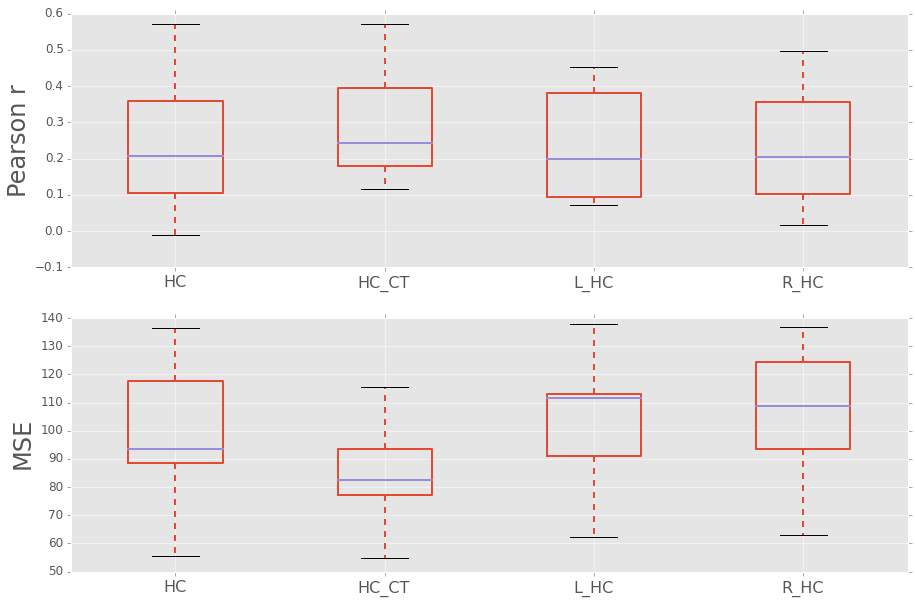

In [28]:
# Boxplots for CV statistics (r, mse, R2)
import pandas as pd
stat_measure_list = [boxplot_config_r,boxplot_config_MSE]
stat_measure_names = ['Pearson r', 'MSE']
from matplotlib.artist import setp
plt.figure()
font_small = 12
font_med = 16
font_large = 24
plt.style.use('ggplot')

for sm, stat_measure in enumerate(stat_measure_list):
    plt.subplot(2,1,sm+1)
    df_array = pd.DataFrame(dict([ (k,pd.Series(v[0])) for k,v in stat_measure.iteritems() ]))
    bplot = df_array.boxplot(column=stat_measure.keys(), fontsize=font_large)
    #plt.xlabel('Method',fontsize=font_large)
    plt.ylabel(stat_measure_names[sm],fontsize=font_large)
    plt.xticks(fontsize=font_med)
    plt.yticks(fontsize=font_small)
    setp(bplot['boxes'], linewidth=2)
    setp(bplot['whiskers'], linewidth=2)
    setp(bplot['fliers'], linewidth=2)
    setp(bplot['medians'], linewidth=2)
    
plt.show()

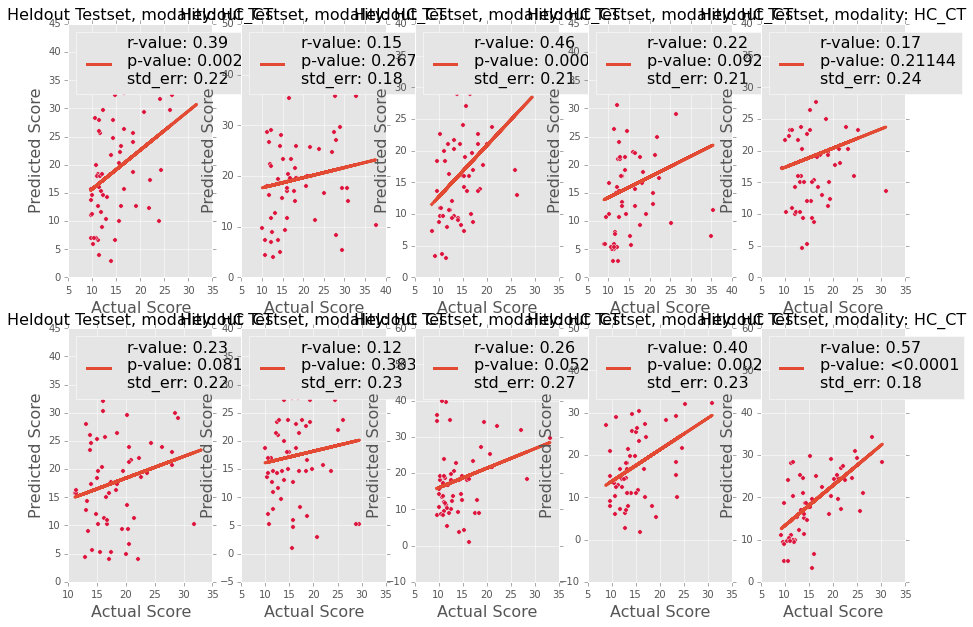

In [26]:
# Plot correlations from the predictions
save_plt_data = True
n_rows = 2
n_cols = (n_folds+1)/n_rows

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
plt.figure()

plt.style.use('ggplot')
font_small = 8
font_med = 16
font_large = 24
r_fold = []
r_pear = []
if innerLoop:
    loop_name = 'Inner Fold' 
else:
    loop_name = 'Outer Fold'

for i in np.arange(n_folds):
    x = np.squeeze(X_out[i])
    y = np.squeeze(labels[i])
    
    if save_plt_data: #save the data to be plotter later.. (montages etc..)
        montage_dir = '/projects/nikhil/ADNI_prediction/caffe_output/montage_data/'
        mydict = {'predicted_score': x, 'actual_score': y}
        output = open('{}corr_data_{}_T{}.pkl'.format(montage_dir,modality,tid), 'wb')
        pickle.dump(mydict, output)
        output.close()
        
    plt.subplot(n_rows,n_cols,i+1)
    #plt.subplot(n_rows,n_cols,2)
    plt.scatter(x, y, c='crimson',s=20)
    fit = np.polyfit(x,y,1)
    fit_fn = np.poly1d(fit) 
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    r_fold.append(r_value)    
    if p_value < 0.0001:
        p_value_sig = '<0.0001'
    else:
        p_value_sig = '{:.5f}'.format(p_value)
        
    label_str = 'r-value: {:04.2f}'.format(r_value) + '\n' + 'p-value: ' + p_value_sig + '\n' + 'std_err: {:04.2f}'.format(std_err) 
    # fit_fn is now a function which takes in x and returns an estimate for y
    plt.plot(x, fit_fn(x),linewidth=3, label=label_str)
    
    #title_str = '{}: {} Validation'.format(loop_name, i+1) # CV 
    title_str = 'Heldout Testset, modality: {}'.format(modality)  #heldout Test set
    plt.title(title_str,fontsize=font_med)
    plt.xlabel('Actual Score',fontsize=font_med)
    plt.ylabel('Predicted Score',fontsize=font_med)            
    plt.legend(fontsize=font_med,loc=2)

plt.show()
# plt.savefig('/projects/nikhil/ADNI_prediction/visuals/Classification/corr_{}.png'.format(modality), bbox_inches='tight')

In [13]:
# QC HC volume indexing and correlation with the ADAS score.. must be around -0.25 
import pickle
test_X = load_data('/projects/nikhil/ADNI_prediction/input_datasets/HC_CT_inflated_CV_OuterFolds_test_partition_fused.h5', 'heldout_X_L_HC')
test_y = load_data('/projects/nikhil/ADNI_prediction/input_datasets/HC_CT_inflated_CV_OuterFolds_test_partition_fused.h5', 'heldout_y')
#print stats.pearsonr(x,test_y)
#plt.hist(test_y)
#plt.show()

#fuse_path = '/projects/nikhil/miccai/input_data_comb/data_t300_adcn.h5'
test_fuse_path = '/projects/nikhil/ADNI_prediction/input_datasets/ordered_fused_ad_cn_mci_test.h5'
test_L_HC = load_data(test_fuse_path, 'l_hc_features_fused')
test_R_HC = load_data(test_fuse_path, 'r_hc_features_fused')

val_fuse_path = '/projects/nikhil/ADNI_prediction/input_datasets/ordered_fused_ad_cn_mci_valid.h5'
val_L_HC = load_data(val_fuse_path, 'l_hc_features_fused')
val_R_HC = load_data(val_fuse_path, 'r_hc_features_fused')

train_fuse_path = '/projects/nikhil/ADNI_prediction/input_datasets/ordered_fused_ad_cn_mci_train.h5'
train_L_HC = load_data(train_fuse_path, 'l_hc_features_fused')
train_R_HC = load_data(train_fuse_path, 'r_hc_features_fused')

train_val_file = '/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_seg_fused_train_plus_val.pkl'
test_file = '/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_seg_fused_test.pkl'

print 'train shape: {}'.format(train_L_HC.shape)
print 'val shape: {}'.format(val_L_HC.shape)

train_val_L_HC = np.vstack((train_L_HC,val_L_HC))

f = open(train_val_file)
train_val_data = pickle.load(f)
f = open(test_file)
test_data = pickle.load(f)

#print test_data['L_HC_VOL']
#print test_data['ADAS13']
print 'pkl file data: {}'.format(stats.pearsonr(test_data['L_HC_VOL'], test_data['ADAS13']))
print 'hdf file data: {}'.format(stats.pearsonr(test_data['L_HC_VOL'], test_y))
print 'this should be 1: {}'.format(stats.pearsonr(test_data['ADAS13'], test_y))

print "train val HC corrleations from HDF files"
hdf_train_L_HC = np.array(np.sum(train_val_L_HC,axis=1))
idx = np.array(np.isfinite(train_val_data['ADAS13']))
#print idx
score = train_val_data['ADAS13']
print 'train_val hdf score shape: {}'.format(score.shape)
score = score[idx]
print 'train_val hdf trunc score shape: {}'.format(score.shape)
hdf_train_L_HC_trunc = hdf_train_L_HC[idx]

print 'hdf_train_L shape {}'.format(hdf_train_L_HC_trunc.shape)
print stats.pearsonr(hdf_train_L_HC_trunc[:490],score[:490])
print stats.pearsonr(hdf_train_L_HC_trunc[490:],score[490:])

print "train val HC corrleations from CSV files"
train_val_data = train_val_data[np.isfinite(train_val_data['ADAS13'])]
print stats.pearsonr(train_val_data['L_HC_VOL'], train_val_data['ADAS13'])
print stats.pearsonr(train_val_data['L_HC_VOL'][:490], train_val_data['ADAS13'][:490])
print stats.pearsonr(train_val_data['L_HC_VOL'][490:], train_val_data['ADAS13'][490:])

print train_val_L_HC.shape, train_val_data['L_HC_VOL'].shape, train_val_data['ADAS13'].shape

#print np.sum(train_val_L_HC,axis=1)
#print zip(np.sum(train_val_L_HC,axis=1), np.array(train_val_data['L_HC_VOL']))


train shape: (490, 11427)
val shape: (98, 11427)
pkl file data: (-0.2950559398991211, 0.0017528539222817342)
hdf file data: (-0.2950559398991211, 0.0017528539222817342)
this should be 1: (1.0, 0.0)
train val HC corrleations from HDF files
train_val hdf score shape: (588,)
train_val hdf trunc score shape: (581,)
hdf_train_L shape (581,)
(-0.024741706229790127, 0.5848144660901593)
(0.016954941950176005, 0.87326281597313615)
train val HC corrleations from CSV files
(-0.30647962666760803, 4.2212150433654121e-14)
(-0.30469415363284857, 5.5006949384961788e-12)
(-0.31208009247699003, 0.0025996501249539801)
(588, 11427) (581,) (581,)


In [26]:
OF_valid_file = 'HC_CT_inflated_CV_OuterFolds_valid_partition_fused.h5'
heldout_test_file = 'HC_CT_inflated_CV_OuterFolds_test_partition_fused.h5'

print 'valid fused QC'
for i in np.arange(1,11,1):
    val_data_X = load_data(input_data_dir_path + OF_valid_file,'Fold_{}_X_R_HC'.format(i))
    val_data_y = load_data(input_data_dir_path + OF_valid_file,'Fold_{}_y'.format(i))
    print 'r fold {}: {}'.format(i,stats.pearsonr(np.sum(val_data_X,axis=1),val_data_y)) 

print 'test fused QC'
test_data_X = load_data(input_data_dir_path + heldout_test_file,'heldout_X_R_HC')
test_data_y = load_data(input_data_dir_path + heldout_test_file,'heldout_y')
print 'r heldout: {}'.format(stats.pearsonr(np.sum(test_data_X,axis=1),test_data_y)) 

inflated_CV_file = 'inflated_datasets/total_HC_vol_CT_inflated_CV_subsets_ROI_74.h5'

for i in np.arange(1,11,1):
    train_data_X = load_data(input_data_dir_path + inflated_CV_file,'Fold_{}_train_X_L_HC'.format(i))
    train_data_y = load_data(input_data_dir_path + inflated_CV_file,'Fold_{}_train_y'.format(i))    
    val_data_X = load_data(input_data_dir_path + inflated_CV_file,'Fold_{}_valid_X_L_HC'.format(i))
    val_data_y = load_data(input_data_dir_path + inflated_CV_file,'Fold_{}_valid_y'.format(i))
    print 'r fold {}, train:{}, val:{}'.format(i,stats.pearsonr(train_data_X,train_data_y),stats.pearsonr(val_data_X,val_data_y)) 



valid fused QC
r fold 1: (-0.32763280575764625, 0.011306213307692992)
r fold 2: (-0.15769638451120024, 0.23710625202277927)
r fold 3: (-0.34913715701141657, 0.0072276574432076947)
r fold 4: (-0.12880035087226546, 0.33525536007642176)
r fold 5: (-0.34329008104953851, 0.0083345636530081299)
r fold 6: (-0.43145075795558391, 0.0007210995924838633)
r fold 7: (-0.34685746286171359, 0.0076429409870360527)
r fold 8: (-0.34264060981961186, 0.008466174378184586)
r fold 9: (-0.36739106890002005, 0.0045538700000737628)
r fold 10: (-0.33661389099204353, 0.0097762075414746085)
test fused QC
r heldout: (-0.2833963839281175, 0.0026989813463541832)
r fold 1, train:(-0.15825170547682321, 4.5120639485563531e-203), val:(-0.21554546643268452, 1.8788738352467056e-42)
r fold 2, train:(-0.15837264888989058, 5.0418172699070812e-204), val:(-0.21410115436712948, 2.0513793343929479e-41)
r fold 3, train:(-0.15796724482894067, 5.6006284570350847e-203), val:(-0.24291702034446488, 1.686098923579052e-65)
r fold 4, tra

In [ ]:
#Create Train + Val subset for "Exemplar Model" training
baseline_dir= '/projects/nikhil/ADNI_prediction/input_datasets/inflated_datasets/'
exemplar_train_file = 'HC_CT_inflated_Exemplar_train_partition_subsets_ROI_74.h5'
lid=1
ignore_cols = True

input_data_train_X = load_data(baseline_dir + 'HC_CT_inflated_CV_subsets.h5','Fold_{}_train_X'.format(lid))
input_data_train_y = load_data(baseline_dir + 'HC_CT_inflated_CV_subsets.h5','Fold_{}_train_y'.format(lid))

input_data_valid_X = load_data(baseline_dir + 'HC_CT_inflated_CV_subsets.h5','Fold_{}_valid_X'.format(lid))
input_data_valid_y = load_data(baseline_dir + 'HC_CT_inflated_CV_subsets.h5','Fold_{}_valid_y'.format(lid))

out_train_X_raw = np.vstack((input_data_train_X, input_data_valid_X))
heldout_train_y = np.concatenate((input_data_train_y, input_data_valid_y))

#if you want to remove some CT columes (74 connundrum)
L_HC_offset=11427
R_HC_offset=10519
if ignore_cols:
    ignore_list_CT_idx = list(L_HC_offset + R_HC_offset + np.array([0,29,30,37,38]))
    heldout_train_X = np.delete(out_train_X_raw, np.s_[ignore_list_CT_idx], 1)    
else:
    heldout_train_X = out_train_X_raw

test_fused_data = h5.File(baseline_dir + exemplar_train_file,'a')
test_fused_data.create_dataset('heldout_X_L_HC',data=heldout_train_X[:,:L_HC_offset])
test_fused_data.create_dataset('heldout_X_R_HC',data=heldout_train_X[:,L_HC_offset:L_HC_offset+R_HC_offset])
test_fused_data.create_dataset('heldout_X_CT',data=heldout_train_X[:,L_HC_offset+R_HC_offset:])    
test_fused_data.create_dataset('heldout_y',data=heldout_train_y)
test_fused_data.close()


In [ ]:
from math import sqrt
import numpy as np
import h5py as h5
from scipy.stats.mstats_basic import mquantiles
from sklearn.utils.extmath import randomized_svd
import tables as tb
import sys
import os
#import lmdb
import matplotlib.pyplot as plt
from scipy.stats import describe
from sklearn.manifold import TSNE
from sklearn.decomposition import RandomizedPCA
#from activations import visualize_activations, hinton
from scipy.spatial.distance import dice

def get3DVol(HC_input, HC_shape, input_mask):
    flatvol = np.zeros(np.prod(HC_shape))
    flatvol[input_mask] = HC_input
    vol = flatvol.reshape(-1, HC_shape[2]).T
    return vol

def plot_slices(slice_list, baseline_shape, baseline_mask, llimit=0.01, ulimit=0.99, xmin=200, xmax=1600):
    """
    Plot dem slices.
    :param slice_list:
    :param llimit:
    :param ulimit:
    :param num_slices:
    :param xmin:
    :param xmax:
    :return:
    """
    num_slices = len(slice_list)
    plt.style.use('ggplot')
    plt.figure()
    cols = 2
    rows = num_slices / cols
    plt.cla()
    for j, input in enumerate(slice_list):
        quantiles = mquantiles(input[0], [llimit, ulimit])
        wt_vol = get3DVol(input[0], baseline_shape, baseline_mask)
        plt.subplot(rows, cols, j + 1)
        im = plt.imshow(wt_vol[:, xmin:xmax], cmap=plt.cm.Reds, aspect='auto', interpolation='none', vmin=-.06, vmax=0.06)
        plt.grid()
        plt.title(input[1])
        plt.colorbar()
        im.set_clim(quantiles[0], quantiles[1])
        plt.axis('off')
        
def getDice(X,X_hat):    
    X.astype(int)
    X_hat_r = np.round(X_hat)
    X_hat_r.astype(int)
    d=[]
    for i in np.arange(X.shape[0]):
        d.append(dice(X[i,:],X_hat_r[i,:]))
    return d


In [ ]:
from sklearn.manifold import TSNE
#layer_names = ['encoder1','encoder2','encoder3','code']
layer_names = ['encoder1','encoder2','code']

act_title = 'test_35_T10k.h5'

layer_acts = []
input_file = '/projects/nikhil/miccai/visuals/train_logs/' + act_title
input_data = h5.File(input_file, 'r')
for layer in layer_names:
    layer_acts.append(input_data[layer][:])

X_hat = input_data['output_Sigmoid'][:]
input_data.close()

sampx = np.shape(X_hat)[0]

sim=0
# simulation
if sim==1:
    input_file = '/projects/nikhil/miccai/input_data_comb/HC_sim_cat4_data_2.h5'
    input_data = h5.File(input_file, 'r')
    features = input_data['train_data_1'][:]
    labels = input_data['train_classes_1'][:]
    input_data.close()

    ind0 = np.where(labels[:sampx] == 0)[0]
    ind1 = np.where(labels[:sampx] == 1)[0]
    ind2 = np.where(labels[:sampx] == 2)[0]
    ind3 = np.where(labels[:sampx] == 3)[0]
    
else:
    input_file = '/projects/nikhil/miccai/visuals/train_logs/ad_cn_test.h5'
    input_data = h5.File(input_file, 'r')
    features = input_data['l_hc_features'][:]
    labels = input_data['label'][:]
    input_data.close()
    ind0 = np.where(labels[:sampx] == 0)[0]
    ind1 = np.where(labels[:sampx] == 1)[0]

X = features[:sampx,:]

#recon_dice = getDice(X, X_hat)
#print "mean dice scores of the test sample reconstructions: " + str(np.mean(recon_dice))

    
plt.figure()
for i in np.arange(len(layer_acts)):
    activations = layer_acts[i]
    print layer_names[i] + " :" + str(np.mean(activations))
    if activations.shape[1] != 1:
        tsne = TSNE(n_components=2, random_state=0, init='pca')
        proj = tsne.fit_transform(activations.astype(float))
    else:
        proj = activations
    
    plt.subplot(2,2,i+1)
    plt.scatter(proj[ind0, 0], proj[ind0, 1], c='mediumturquoise', alpha=0.7,label='AD')
    plt.scatter(proj[ind1, 0], proj[ind1, 1], c='slategray', alpha=0.7,label='CN')
    
    if sim==1:
        plt.scatter(proj[ind2, 0], proj[ind2, 1], c='mediumpurple', alpha=0.7,label='grp3')
        plt.scatter(proj[ind3, 0], proj[ind3, 1], c='darksalmon', alpha=0.7,label='grp4')
        
        
    plt.title(layer_names[i] + ' layer activations')
    plt.legend()

plt.show()

In [ ]:
# Visualize inputs vs their reconstructions:
mappings = tb.open_file('/projects/nikhil/miccai/visuals/train_logs/data_mappings.h5', 'r')
baseline_mask = mappings.get_node('/r_datamask')[:]
volmask = mappings.get_node('/r_volmask')[:]
mappings.close()
baseline_shape = volmask.shape

plot_list = []
for x in range(6):
    i = np.random.random_integers(sampx)
    plot_list.append((X[i], 'X {}'.format(i)))
    plot_list.append((np.round(X_hat[i]), 'X_hat {}'.format(i)))
    
plot_slices(plot_list, baseline_shape, baseline_mask)
plt.show()

In [ ]:
a=0.7
plt.figure()
plt.hist(np.sum(features[labels==0],axis=1),alpha=a,normed=1,bins=50,label='AD')
plt.hist(np.sum(features[labels==1],axis=1),alpha=a,normed=1,bins=50,label='CN')
plt.legend()
plt.show()

In [ ]:
# simulation
input_file = '/projects/nikhil/miccai/input_data_comb/HC_sim_cat4_data_2.h5'
input_data = h5.File(input_file, 'r')
features_all = input_data['train_data_1'][:]
labels = input_data['train_classes_1'][:]
input_data.close()
#Missing HC cases :-P 
vols = np.sum(features_all,axis=1)
empty_rows = np.where(vols!=0)[0]
features = features_all[empty_rows,:]

In [ ]:
#PCA
from sklearn.decomposition import RandomizedPCA
from sklearn.externals import joblib
n_components=64
train_pca = RandomizedPCA(n_components=n_components).fit(features)
features_loadings = train_pca.transform(features)    

In [ ]:
pca_dice=[]
for i in np.arange(5):
    print i        
    feature_recon = np.dot(features_loadings[:,:i],train_pca.components_[:i,:]) + train_pca.mean_
    pca_dice.append(np.nanmean(getDice(features,feature_recon)))

In [ ]:
36000/128